## Research Question
Are Republican voting states more religious than Democratic ones? Were Republican rallies more focused on states with a higher % of Christian following population during the run-in to the 2020 Presidential election?

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from bs4 import BeautifulSoup

%matplotlib notebook

In [2]:
# Create geopandas df from .shp file found from: 
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
# Help for dealing with geodata was found here:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

fp = 'Geodata/cb_2018_us_state_5m.shp'
map_df = gpd.read_file(fp)

In [3]:
# Extract data for religion by states in US
url = 'https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_religiosity'
religion_by_states = requests.get(url).text
soup = BeautifulSoup(religion_by_states, 'html.parser')

In [4]:
# Create a dataframe using data from wikipedia

table = soup.find('table')
religion_by_states = pd.DataFrame(columns=['State', 'Pro', 'Cat', 'Mor', 'Oth'])

for row in table.tbody.find_all('tr'):
    col = row.find_all('td')
    if (col != []):
        state = col[0].text.strip()
        pro = col[1].text.strip()
        cat = col[2].text.strip()
        mor = col[3].text.strip()
        oth = col[4].text.strip()
        new_row_dict = {'State':[state], 'Pro':[pro], 'Cat':[cat], 'Mor':[mor], 'Oth':[oth]}
        new_row = pd.DataFrame.from_dict(new_row_dict)
        religion_by_states = pd.concat([religion_by_states, new_row], ignore_index=True)
        

In [5]:
# Tidy up dataframe, getting rid of <1.0 values, convert to float, and create total % column

func = lambda x: 0 if x == '<1.0' else x

religion_by_states['Mor'] = religion_by_states['Mor'].apply(func)
religion_by_states['Oth'] = religion_by_states['Oth'].apply(func)
religion_by_states['Pro'] = religion_by_states['Pro'].astype(float)
religion_by_states['Cat'] = religion_by_states['Cat'].astype(float)
religion_by_states['Mor'] = religion_by_states['Mor'].astype(float)
religion_by_states['Oth'] = religion_by_states['Oth'].astype(float)

religion_by_states['Tot'] = religion_by_states['Pro'] + \
                            religion_by_states['Cat'] + religion_by_states['Mor'] + \
                            religion_by_states['Oth']


In [6]:
# Get rid of anything that isn't a mainland US state

map_df.drop([27, 49, 47, 48, 51, 55, 39], inplace=True)

religion_by_states.drop([25, 37, 39], inplace=True)

In [7]:
# Create a list of Trump rallies from wiki data

url = 'https://en.wikipedia.org/wiki/List_of_post%E2%80%932016_election_Donald_Trump_rallies'
trump_rallies = requests.get(url).text
soup = BeautifulSoup(trump_rallies, 'html.parser')

In [8]:
# Create the data series that holds the number of Trump rallies in each state

tables = soup.find_all('table')
df1 = pd.read_html(str(tables[4]), flavor='bs4')[0]
df2 = pd.read_html(str(tables[5]), flavor='bs4')[0]
df3 = pd.read_html(str(tables[6]), flavor='bs4')[0]
df4 = pd.read_html(str(tables[7]), flavor='bs4')[0]
trump_rallies = pd.concat((df1, df2, df3, df4))
trump_rallies = trump_rallies.reset_index()
trump_rallies.drop(['index', 'City', 'Venue', 'Other speakers'], axis=1, inplace=True)
trump_rallies = trump_rallies.groupby('State').agg(len)
trump_rallies.columns = ['Number of rallies']
trump_rallies = trump_rallies['Number of rallies']

In [9]:
# Bring in df with election results of all states
# This csv was created by hand but should be fairly easy to recreate

results = pd.read_csv('election_results')
results.drop('Unnamed: 0', axis=1, inplace=True)

In [10]:
# Create the df for the democratic states and republican states

rep_map_data = map_df.merge(results.where(results['Election result'] == 'Republican').dropna(), 
                            how='inner',
                            left_on='NAME',
                            right_on='State'
                           )
rep_map_data = rep_map_data.merge(religion_by_states, how='inner', left_on='NAME', right_on='State')

dem_map_data = map_df.merge(results.where(results['Election result'] == 'Democrat').dropna(),
                            how='inner',
                            left_on='NAME',
                            right_on='State'
                           )
dem_map_data = dem_map_data.merge(religion_by_states, how='inner', left_on='NAME', right_on='State')


In [11]:
def draw_party(df, religion_by_states):
    """Draw the states that voted for a specific party"""
    # Plot variable can be changed between 'Pro', 'Cat', 'Mor', 'Oth', and 'Tot' 
    plot_variable = 'Tot'
    # Calculate the average value for religious following of chosen variable
    avg_rel = np.mean(religion_by_states[plot_variable])
    for i, row in df.iterrows():
        rel_percent = row[plot_variable]
        draw_state(row, rel_percent, avg_rel)

In [12]:
def draw_state(row, rel_percent, avg_rel):
    """Draw each state"""
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        colour = gen_colour(rel_percent, row['Election result'], avg_rel)
        plt.fill(x, y, color=colour, edgecolor='0.8', linewidth=0.8)
    else:
        # If multipolygon iterate over each polygon
        for geom in row['geometry'].geoms:
            x, y = geom.exterior.xy
            colour = gen_colour(rel_percent, row['Election result'], avg_rel)
            plt.fill(x, y, color=colour, edgecolor='0.8', linewidth=0.8)


In [13]:
def gen_colour(rel_percent, party, avg_rel):
    """Generate the colour used to fill-in each state"""
    # For either party, if state's religious percent is less than average, return a lighter shade of same colour
    if party == 'Democrat':
        if rel_percent < avg_rel:
            return '#3b8df7'
        else:
            return '#0d57a1'
    else:
        if rel_percent < avg_rel:
            return '#F73b3f'
        else:
            return '#ac1117'

<IPython.core.display.Javascript object>


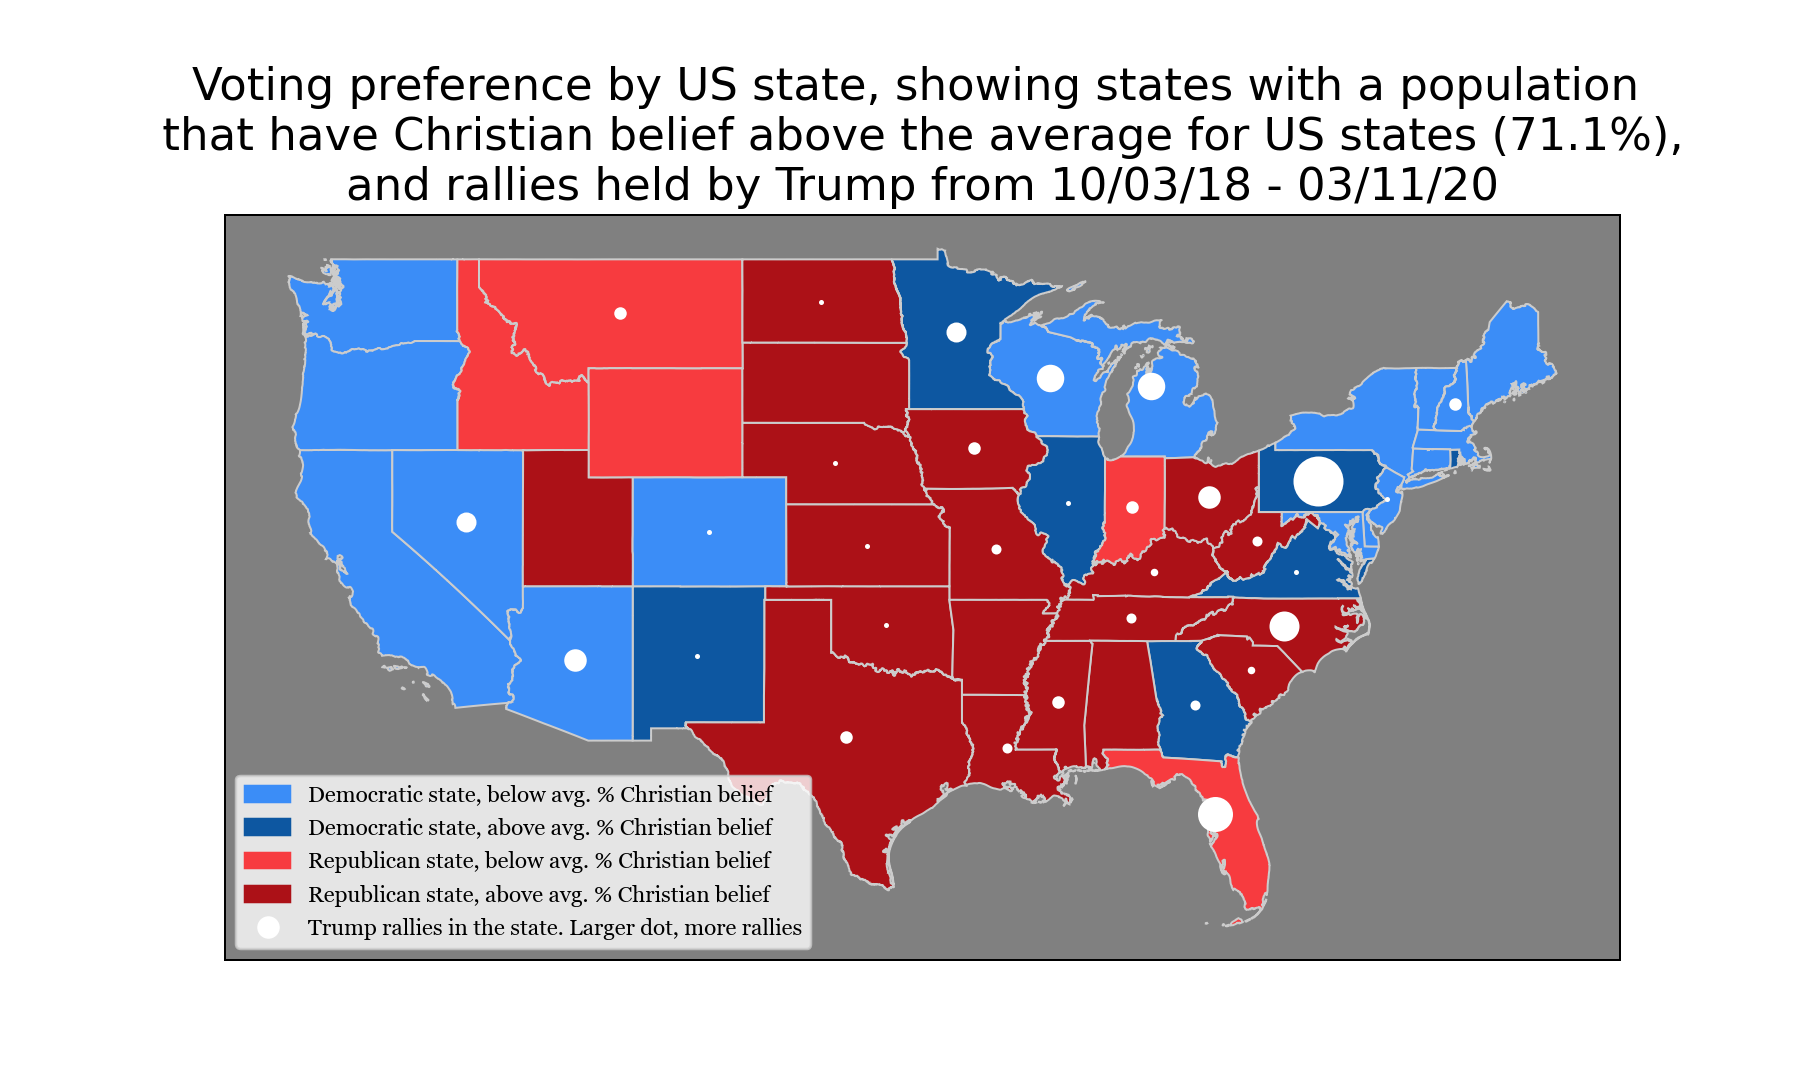

In [14]:
# Create the figure
fig = plt.figure(figsize=(10, 6))

# Draw the states for each party
draw_party(dem_map_data, religion_by_states)
draw_party(rep_map_data, religion_by_states)

# Draw the markers indicating Trump rally locations
for index in trump_rallies.index:
    count = trump_rallies.loc[index]
    geom = map_df.where(map_df['STUSPS'] == index).dropna()['geometry'].iloc[0]
    x, y = geom.centroid.coords[0]
    plt.plot(x, y, 'o', markersize=count, color='white')

# Set the font family for the whole figure    
mpl.rc('font', family='Georgia')

# Make room for the heading
plt.subplots_adjust(top=0.8)

fig.gca().set_title(
'Voting preference by US state, showing states with a population \n \
that have Christian belief above the average for US states (71.1%), \nand rallies \
held by Trump from 10/03/18 - 03/11/20', 
    {'fontsize':18})

# Change plot background colour to grey and remove axes
fig.gca().set_facecolor('#808080')
fig.gca().tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)    

# Create proxy artists to add to the legend
dem_1_patch = mpatches.Patch(color='#3b8df7', label='Democratic state, below avg. % Christian belief')
dem_2_patch = mpatches.Patch(color='#0d57a1', label='Democratic state, above avg. % Christian belief')
rep_1_patch = mpatches.Patch(color='#F73b3f', label='Republican state, below avg. % Christian belief')
rep_2_patch = mpatches.Patch(color='#ac1117', label='Republican state, above avg. % Christian belief')
rally_patch = mlines.Line2D([], [], color='#e5e5e5', marker='o', markersize=10, markerfacecolor='white',
                            label='Trump rallies in the state. Larger dot, more rallies')

_ = fig.gca().legend(handles=[dem_1_patch, dem_2_patch, rep_1_patch, rep_2_patch, rally_patch], fontsize=9)


In [17]:
avg_rel = np.mean(religion_by_states['Tot'])
dem_states = len(dem_map_data.where(dem_map_data['Tot'] >= avg_rel).dropna())
rep_states = len(rep_map_data.where(rep_map_data['Tot'] >= avg_rel).dropna())
dem_perc = dem_states/len(dem_map_data)
rep_perc = rep_states/len(rep_map_data)
trump_rallies

State
AZ     8
CO     1
FL    13
GA     3
IA     4
IL     1
IN     4
KS     1
KY     2
LA     3
MI    10
MN     7
MO     3
MS     4
MT     4
NC    11
ND     1
NE     1
NH     4
NJ     1
NM     1
NV     7
OH     8
OK     1
PA    19
SC     2
TN     3
TX     4
VA     1
WI    10
WV     3
Name: Number of rallies, dtype: int64

In [391]:
# fig.savefig('assignment4.png', dpi=300)